In [161]:
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score

## Device Agnostic Code

In [162]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## Data PreProcessing

### Reading the data

In [163]:
data = pd.read_csv("./dataset-regression/student-mat.csv", sep=';')
data.head()

,school,sex,age,address,famsize,Pstatus,Medu,Fedu,Mjob,Fjob,...,famrel,freetime,goout,Dalc,Walc,health,absences,G1,G2,G3
0,GP,F,18,U,GT3,A,4,4,at_home,teacher,...,4,3,4,1,1,3,6,5,6,6
1,GP,F,17,U,GT3,T,1,1,at_home,other,...,5,3,3,1,1,3,4,5,5,6
2,GP,F,15,U,LE3,T,1,1,at_home,other,...,4,3,2,2,3,3,10,7,8,10
3,GP,F,15,U,GT3,T,4,2,health,services,...,3,2,2,1,1,5,2,15,14,15
4,GP,F,16,U,GT3,T,3,3,other,other,...,4,3,2,1,2,5,4,6,10,10


### Trimming the data

In [164]:
data = data[["studytime", "failures", "freetime", "absences", "G1", "G2", "G3"]]
data.head()

,studytime,failures,freetime,absences,G1,G2,G3
0,2,0,3,6,5,6,6
1,2,0,3,4,5,5,6
2,2,3,3,10,7,8,10
3,3,0,2,2,15,14,15
4,2,0,3,4,6,10,10


In [165]:
featues = data[["studytime", "failures", "freetime", "absences", "G1", "G2"]]
target = data["G3"]

In [166]:
# Scale the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(featues)

### Split the data

In [167]:
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target, test_size=0.2, random_state=32)

In [168]:
# convert pandas series to numpy
y_train = y_train.to_numpy()
y_test = y_test.to_numpy()

In [169]:
x_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
x_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1,1).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1,1).to(device)

In [170]:
# checking the dimensions if they match

print(x_test_tensor.shape, x_train_tensor.shape)
print(y_test_tensor.shape, y_train_tensor.shape)

torch.Size([79, 6]) torch.Size([316, 6])
torch.Size([79, 1]) torch.Size([316, 1])


## Creating Regression Model 

In [171]:
class RegressionModel(nn.Module):
    def __init__(self):
        super(RegressionModel, self).__init__()
        self.layer_1 = nn.Linear(in_features=6, out_features=12)
        self.layer_2 = nn.Linear(in_features=12, out_features=12)
        self.layer_3 = nn.Linear(in_features=12, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model = RegressionModel().to(device)

### Setup Loss Function and Optimizer

In [172]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

epochs = 20000

### Training Loop

In [173]:
loss_arr = []
epoch_arr = []

for epoch in range(epochs):
    model.train()

    # Forward pass
    outputs = model(x_test_tensor)
    loss = loss_fn(outputs, y_test_tensor)

    # Backward pass and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if (epoch+1) % 1000 == 0:
        loss_arr.append(loss)
        epoch_arr.append(epoch+1)
        print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

Epoch [1000/20000], Loss: 104.5660
Epoch [2000/20000], Loss: 48.0217
Epoch [3000/20000], Loss: 14.7787
Epoch [4000/20000], Loss: 7.9664
Epoch [5000/20000], Loss: 5.8048
Epoch [6000/20000], Loss: 4.5072
Epoch [7000/20000], Loss: 3.6925
Epoch [8000/20000], Loss: 3.2020
Epoch [9000/20000], Loss: 2.9094
Epoch [10000/20000], Loss: 2.6705
Epoch [11000/20000], Loss: 2.4743
Epoch [12000/20000], Loss: 2.2418
Epoch [13000/20000], Loss: 2.0149
Epoch [14000/20000], Loss: 1.8351
Epoch [15000/20000], Loss: 1.6848
Epoch [16000/20000], Loss: 1.5069
Epoch [17000/20000], Loss: 1.3305
Epoch [18000/20000], Loss: 1.1999
Epoch [19000/20000], Loss: 1.0825
Epoch [20000/20000], Loss: 0.9851


### Plotting Loss Function

In [174]:
loss_arr = [ loss.item() for loss in loss_arr ]

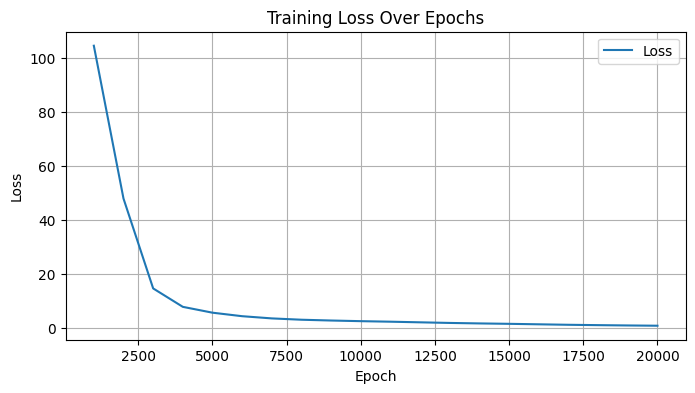

In [175]:
plt.figure(figsize=(8, 4))
plt.plot(epoch_arr, loss_arr ,label='Loss')
plt.title('Training Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()

## Testing the Model

In [176]:
model.eval()

with torch.inference_mode():
    test_output = model(x_test_tensor)
    test_loss = loss_fn(test_output, y_test_tensor)
print(test_loss.item())


0.9850262999534607


## Comparing Actual and Predicted Data

In [177]:
# Create a DataFrame with actual and predicted data
test_data_df = pd.DataFrame({
    'Actual': y_test_tensor.numpy().flatten(),
    'Predicted': test_output.numpy().flatten()
})

test_data_df.head()

,Actual,Predicted
0,0.0,2.534895
1,14.0,13.583518
2,11.0,10.403481
3,11.0,11.755697
4,11.0,11.051180


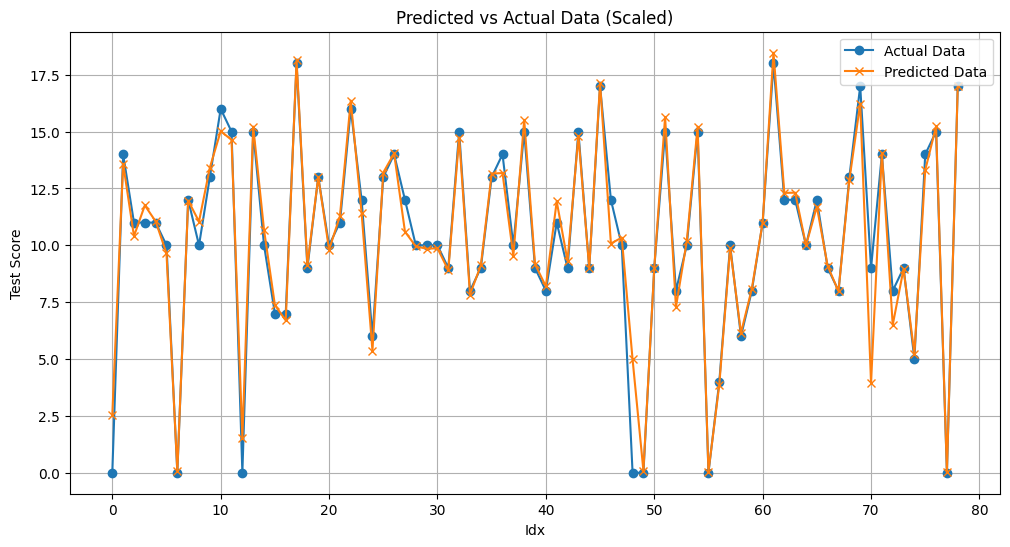

In [178]:
# Plotting the actual and predicted data

plt.figure(figsize=(12,6))
plt.plot(test_data_df['Actual'], label='Actual Data', marker='o')
plt.plot(test_data_df['Predicted'], label='Predicted Data', marker='x')
plt.ylabel('Test Score')
plt.xlabel('Idx')
plt.legend()
plt.title('Predicted vs Actual Data (Scaled)')
plt.grid()
plt.show()

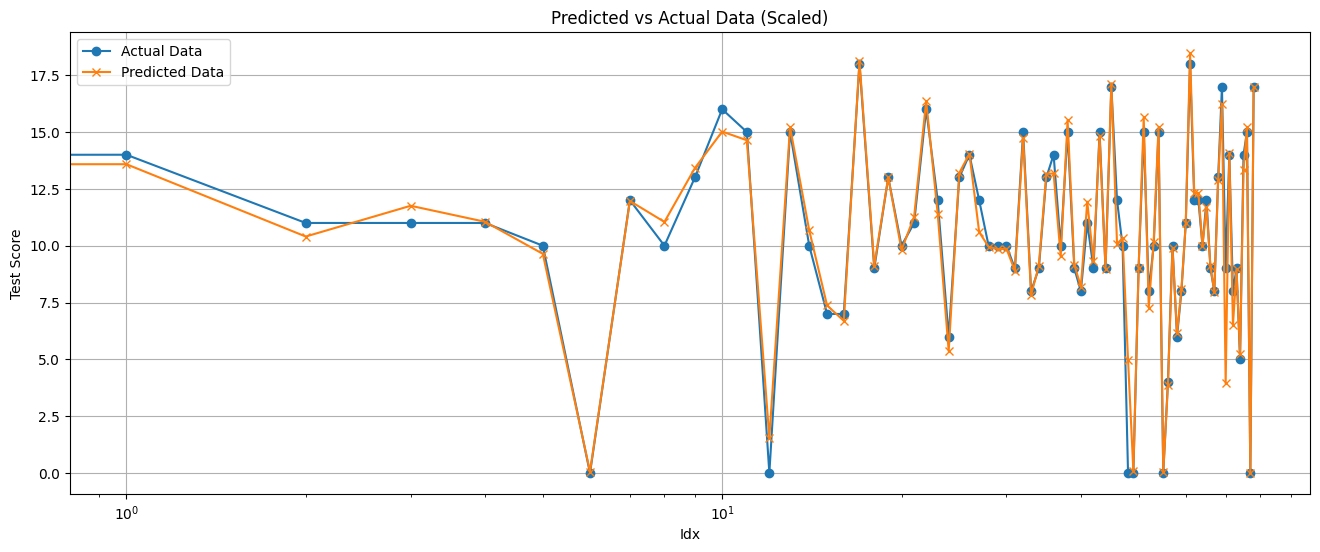

In [179]:
# Plotting the actual and predicted data

plt.figure(figsize=(16,6))
plt.plot(test_data_df['Actual'], label='Actual Data', marker='o')
plt.plot(test_data_df['Predicted'], label='Predicted Data', marker='x')
plt.ylabel('Test Score')
plt.xlabel('Idx')
plt.legend()
plt.xscale('log')
plt.title('Predicted vs Actual Data (Scaled)')
plt.grid()
plt.show()

## R2 Score

r-squared shows how well the data fit the regression model (the goodness of fit)

<img src="https://i0.wp.com/www.fairlynerdy.com/wp-content/uploads/2017/01/r_squared_5.png?resize=625%2C193" alt="error function" width="500"/>


In [181]:
r2 = r2_score(y_test_tensor.numpy(), test_output.numpy())
print(f'R2 Score of the model is {r2: .2f}')

R2 Score of the model is  0.95
